# Lab 1 - Partie 3: CNN avec augmentation des données sur MNIST

Cours: Deep Learning pour l'analyse d'image  
Objectif: Entraîner un réseau CNN sur MNIST et tester l'augmentation de données (rotation et translation)

Dans la partie 2, on utilisait un MLP qui transformait les images en vecteurs plats.  
Ici, on garde la structure 2D des images (1, 28, 28) avec des CNN.

Idée clé: si on entraîne avec des images tournées et décalées, le modèle sera plus robuste à ces transformations.

---
## Ce qu'on va faire
1. Entraîner un CNN de base sur MNIST normal
2. Entraîner le même CNN avec augmentation (rotation + translation)
3. Comparer la précision sur deux versions du test:
   - test MNIST standard
   - test MNIST avec transformations
---

## 0) Configuration GPU

Sur Colab: Runtime → Change runtime type → GPU  
Puis exécuter la cellule ci-dessous.

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: Tesla T4


## 1) Bibliothèques nécessaires

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


## 2) Préparation des données MNIST

On va créer 4 versions du dataset:

1. Train sans augmentation: MNIST normal  
2. Train avec augmentation: MNIST avec rotation et translation 
3. Test standard: MNIST test normal  
4. Test transformé: MNIST test avec les mêmes transformations (pour tester la robustesse)

Augmentations utilisées:
- Rotation: jusqu'à 35 degrés dans les deux sens
- Translation: jusqu'à 30% de la taille de l'image

Ça simule la réalité où les chiffres ne sont pas toujours parfaitement centrés.

In [3]:
torch.manual_seed(0)

# Transform standard: juste convertir en tenseur
transform_normal = transforms.ToTensor()

# Transform avec augmentation: rotation et translation
transform_augmente = transforms.Compose([
    transforms.RandomAffine(degrees=35, translate=(0.3, 0.3)),
    transforms.ToTensor()
])

# Transform pour le test transformé
transform_test_aug = transforms.Compose([
    transforms.RandomAffine(degrees=35, translate=(0.3, 0.3)),
    transforms.ToTensor()
])

# Charger les 4 datasets
data_train_normal = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_normal
)

data_train_augmente = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_augmente
)

data_test_normal = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform_normal
)

data_test_transforme = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform_test_aug
)

print("Nombre d'exemples:", len(data_train_normal), len(data_train_augmente), len(data_test_normal), len(data_test_transforme))

Nombre d'exemples: 60000 60000 10000 10000


### Visualisation rapide (standard vs augmenté)

Si l'augmentation marche, vous devriez voir des chiffres légèrement tournés et décalés.

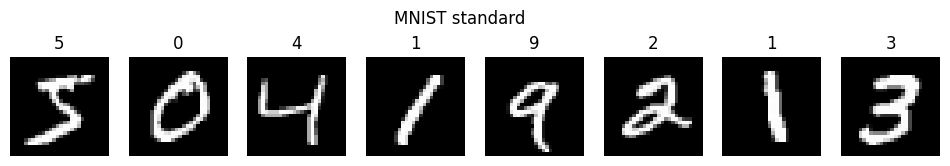

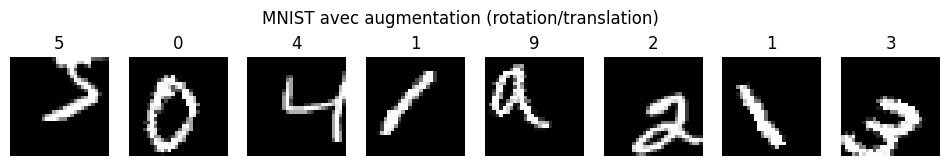

In [4]:
def afficher_exemples(dataset, titre, nb=8):
    plt.figure(figsize=(12, 2))
    for i in range(nb):
        image, etiquette = dataset[i]
        plt.subplot(1, nb, i+1)
        plt.imshow(image.squeeze(0), cmap="gray")
        plt.title(str(etiquette))
        plt.axis("off")
    plt.suptitle(titre)
    plt.show()

afficher_exemples(data_train_normal, "MNIST standard")
afficher_exemples(data_train_augmente, "MNIST avec augmentation (rotation/translation)")

## 3) DataLoaders

On utilise des mini-batches. Si vous manquez de mémoire, réduisez batch_size.

In [5]:
taille_batch = 128

loader_train_normal = DataLoader(data_train_normal, batch_size=taille_batch, shuffle=True)
loader_train_augmente = DataLoader(data_train_augmente, batch_size=taille_batch, shuffle=True)

loader_test_normal = DataLoader(data_test_normal, batch_size=taille_batch, shuffle=False)
loader_test_transforme = DataLoader(data_test_transforme, batch_size=taille_batch, shuffle=False)

## 4) Modèle CNN simple

Architecture du réseau:

- Conv (1 canal vers 16) + ReLU + MaxPool
- Conv (16 vers 32) + ReLU + MaxPool
- Flatten
- Linear (32x7x7 vers 128) + ReLU
- Linear (128 vers 10)

C'est un modèle simple qui s'entraîne rapidement.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Couches convolutionnelles
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # Couches fully connected
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Première conv
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Deuxième conv
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Flatten et fc
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

reseau = CNN().to(device)
print(reseau)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 5) Fonctions d'entraînement et d'évaluation

On utilise:
- Loss: CrossEntropyLoss (pour 10 classes)
- Optimizer: Adam

On va entraîner le même réseau deux fois:
1. sur MNIST normal
2. sur MNIST avec augmentation

In [7]:
loss_fn = nn.CrossEntropyLoss()

def entrainer_une_epoque(reseau, loader, optimiseur):
    reseau.train()
    perte_totale = 0.0
    nb_correct = 0
    nb_total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimiseur.zero_grad()
        sorties = reseau(images)
        perte = loss_fn(sorties, labels)
        perte.backward()
        optimiseur.step()
        
        perte_totale += perte.item()
        _, predictions = torch.max(sorties.data, 1)
        nb_total += labels.size(0)
        nb_correct += (predictions == labels).sum().item()

    return perte_totale / len(loader), nb_correct / nb_total

def evaluer(reseau, loader):
    reseau.eval()
    nb_correct = 0
    nb_total = 0
    perte_totale = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            sorties = reseau(images)
            perte = loss_fn(sorties, labels)
            perte_totale += perte.item()

            _, predictions = torch.max(sorties.data, 1)
            nb_total += labels.size(0)
            nb_correct += (predictions == labels).sum().item()

    return perte_totale / len(loader), nb_correct / nb_total

## 6) Entraîner le CNN de base (sans augmentation)

Vous pouvez augmenter le nombre d'époques si vous voulez.

In [8]:
def entrainer_reseau(loader_train, nb_epochs=3, taux_apprentissage=1e-3):
    reseau = CNN().to(device)
    optimiseur = optim.Adam(reseau.parameters(), lr=taux_apprentissage)

    historique = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(1, nb_epochs + 1):
        perte_train, acc_train = entrainer_une_epoque(reseau, loader_train, optimiseur)
        perte_test, acc_test = evaluer(reseau, loader_test_normal)

        historique["train_loss"].append(perte_train)
        historique["train_acc"].append(acc_train)
        historique["test_loss"].append(perte_test)
        historique["test_acc"].append(acc_test)

        print(f"Epoch {epoch}/{nb_epochs} - loss train: {perte_train:.4f}, acc train: {acc_train:.3f}, acc test: {acc_test:.3f}")
    
    return reseau, historique

nb_epochs = 10
reseau_normal, hist_normal = entrainer_reseau(loader_train_normal, nb_epochs=nb_epochs)

Epoch 1/10 - loss train: 0.2919, acc train: 0.916, acc test: 0.973
Epoch 2/10 - loss train: 0.0742, acc train: 0.977, acc test: 0.984
Epoch 3/10 - loss train: 0.0493, acc train: 0.984, acc test: 0.986
Epoch 4/10 - loss train: 0.0375, acc train: 0.989, acc test: 0.988
Epoch 5/10 - loss train: 0.0301, acc train: 0.991, acc test: 0.990
Epoch 6/10 - loss train: 0.0248, acc train: 0.992, acc test: 0.990
Epoch 7/10 - loss train: 0.0202, acc train: 0.994, acc test: 0.990
Epoch 8/10 - loss train: 0.0165, acc train: 0.995, acc test: 0.988
Epoch 9/10 - loss train: 0.0141, acc train: 0.996, acc test: 0.989
Epoch 10/10 - loss train: 0.0117, acc train: 0.996, acc test: 0.990


## 7) Entraîner le CNN avec augmentation (rotation + translation)

L'augmentation rend l'entraînement plus difficile (plus de variété dans les données), mais améliore la robustesse.

In [9]:
reseau_augmente, hist_augmente = entrainer_reseau(loader_train_augmente, nb_epochs=10)

Epoch 1/10 - loss train: 1.3997, acc train: 0.520, acc test: 0.887
Epoch 2/10 - loss train: 0.6771, acc train: 0.792, acc test: 0.915
Epoch 3/10 - loss train: 0.5053, acc train: 0.844, acc test: 0.940
Epoch 4/10 - loss train: 0.4198, acc train: 0.871, acc test: 0.946
Epoch 5/10 - loss train: 0.3710, acc train: 0.886, acc test: 0.950
Epoch 6/10 - loss train: 0.3326, acc train: 0.898, acc test: 0.956
Epoch 7/10 - loss train: 0.2983, acc train: 0.908, acc test: 0.960
Epoch 8/10 - loss train: 0.2789, acc train: 0.915, acc test: 0.953
Epoch 9/10 - loss train: 0.2592, acc train: 0.920, acc test: 0.962
Epoch 10/10 - loss train: 0.2454, acc train: 0.924, acc test: 0.960


## 8) Tester la robustesse

On évalue les deux réseaux sur:
- Test MNIST standard
- Test MNIST transformé (avec rotation/translation)

Un bon modèle devrait perdre peu de précision sur le test transformé.

In [10]:
loss_n_std, acc_n_std = evaluer(reseau_normal, loader_test_normal)
loss_n_trans, acc_n_trans = evaluer(reseau_normal, loader_test_transforme)
loss_a_std, acc_a_std = evaluer(reseau_augmente, loader_test_normal)
loss_a_trans, acc_a_trans = evaluer(reseau_augmente, loader_test_transforme)

print("--- CNN sans augmentation ---")
print(f"Test standard: {acc_n_std:.3f}")
print(f"Test transformé: {acc_n_trans:.3f}")
print()
print("--- CNN avec augmentation ---")
print(f"Test standard: {acc_a_std:.3f}")
print(f"Test transformé: {acc_a_trans:.3f}")

--- CNN sans augmentation ---
Test standard: 0.990
Test transformé: 0.259

--- CNN avec augmentation ---
Test standard: 0.960
Test transformé: 0.926


### Tracer les courbes d'apprentissage (optionnel)

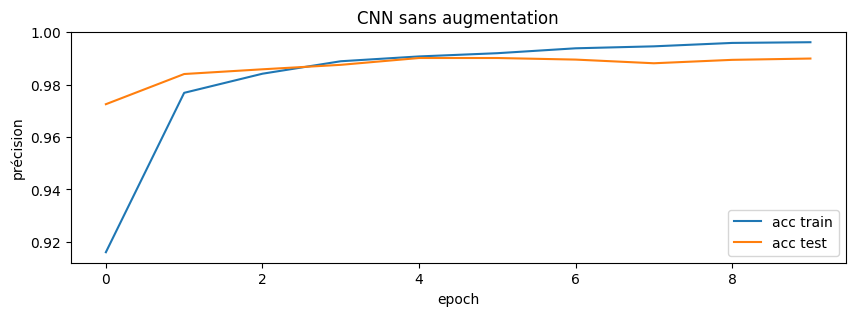

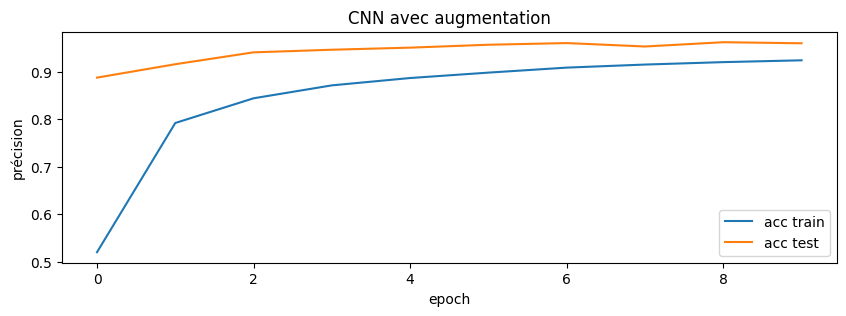

In [11]:
def tracer_courbes(hist, titre):
    plt.figure(figsize=(10, 3))
    plt.plot(hist["train_acc"], label="acc train")
    plt.plot(hist["test_acc"], label="acc test")
    plt.title(titre)
    plt.xlabel("epoch")
    plt.ylabel("précision")
    plt.legend()
    plt.show()

tracer_courbes(hist_normal, "CNN sans augmentation")
tracer_courbes(hist_augmente, "CNN avec augmentation")

## 9) Visualiser ce que le CNN apprend

On va regarder:
1. Les filtres de la première couche de convolution
2. Les cartes d'activation (feature maps) pour une image donnée

Ça permet de voir ce que le CNN détecte.

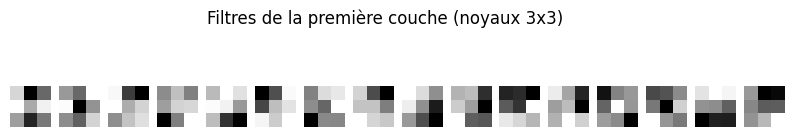

In [12]:
def afficher_filtres_conv1(reseau, max_filtres=16):
    # Récupérer les poids de la première conv
    poids = reseau.conv1.weight.detach().cpu()
    
    nb = min(poids.shape[0], max_filtres)
    plt.figure(figsize=(10, 2))
    for i in range(nb):
        plt.subplot(1, nb, i+1)
        plt.imshow(poids[i, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Filtres de la première couche (noyaux 3x3)")
    plt.show()

afficher_filtres_conv1(reseau_augmente)

### Cartes d'activation (feature maps)

On prend une image du test et on visualise ce qui sort de chaque couche de convolution.

In [13]:
@torch.no_grad()
def obtenir_activations(reseau, x):
    reseau.eval()
    activations = []
    
    # Conv1
    x = reseau.conv1(x)
    x = reseau.relu1(x)
    activations.append(x.detach().cpu())
    x = reseau.pool1(x)
    
    # Conv2
    x = reseau.conv2(x)
    x = reseau.relu2(x)
    activations.append(x.detach().cpu())
    x = reseau.pool2(x)
    
    return activations

# Prendre une image du test
image_test, label_test = data_test_normal[0]
x = image_test.unsqueeze(0).to(device)

activations = obtenir_activations(reseau_augmente, x)

print("Label:", label_test)
print("Tailles des activations:", [a.shape for a in activations])

Label: 7
Tailles des activations: [torch.Size([1, 16, 28, 28]), torch.Size([1, 32, 14, 14])]


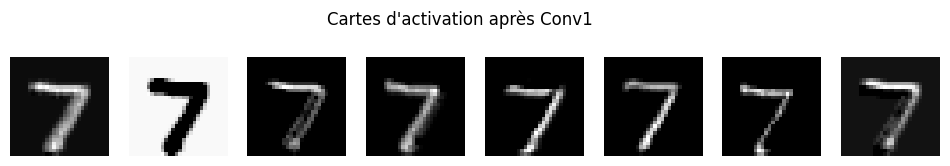

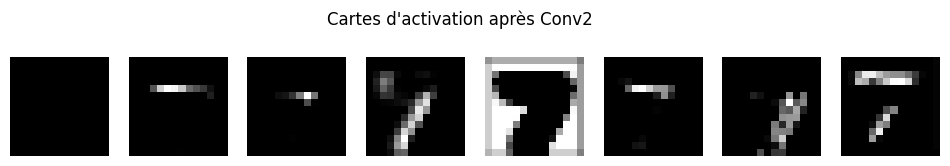

In [14]:
def afficher_feature_maps(activation, titre, max_cartes=8):
    nb_canaux = activation.shape[1]
    nb = min(nb_canaux, max_cartes)
    plt.figure(figsize=(12, 2))
    for i in range(nb):
        plt.subplot(1, nb, i+1)
        plt.imshow(activation[0, i], cmap="gray")
        plt.axis("off")
    plt.suptitle(titre)
    plt.show()

for num, act in enumerate(activations, start=1):
    afficher_feature_maps(act, f"Cartes d'activation après Conv{num}", max_cartes=8)

## 10) Questions finales 

1. Que remarquez-vous en comparant les résultats sur le test standard vs le test transformé pour les deux modèles?
2. Comment l'augmentation aide-t-elle sur le test transformé?
3. Est-ce que l'augmentation améliore toujours la précision sur le test standard? Pourquoi ou pourquoi pas?


Réponses: 

1. Comparaison des résultats

Il y a une différence dramatique entre les deux modèles face aux transformations:

Le CNN sans augmentation s'effondre complètement sur le test transformé (99% → 25.9%, soit une chute de 73%). C'est presque comme si le modèle devinait au hasard.

Le CNN avec augmentation reste stable (96% → 92.6%, soit seulement 3.4% de baisse). Il gère très bien les transformations.

C'est un cas extrême de surapprentissage à la distribution d'entraînement. Le modèle sans augmentation a mémorisé les chiffres dans leurs positions exactes, mais n'a pas appris à reconnaître les formes indépendamment de leur position.



2. Pourquoi l'augmentation aide

L'augmentation force le modèle à voir le même chiffre sous plein d'angles et positions différents pendant l'entraînement. 

Le réseau développe donc une invariance aux transformations géométriques - il reconnaît les patterns visuels indépendamment de leur emplacement ou orientation.

3. Est-ce que ça améliore toujours le test standard?

Non. Dans les résultats, le modèle avec augmentation a une précision inférieure sur le test standard (96% vs 99%).

Pourquoi cette baisse?

- L'augmentation rend l'entraînement plus difficile - le modèle voit des versions "dégradées" des images
- Le modèle doit apprendre des features plus robustes mais moins spécifiques
- Sur un test "facile" (images bien centrées comme dans MNIST standard), un modèle surspécialisé peut faire mieux

Mais attention: Cette baisse de 3% est un petit prix à payer pour gagner 67% de précision sur les cas transformés (25.9% → 92.6%). Dans le monde réel, les données ne sont jamais parfaitement alignées comme MNIST standard, donc l'augmentation est presque toujours bénéfique globalement.

